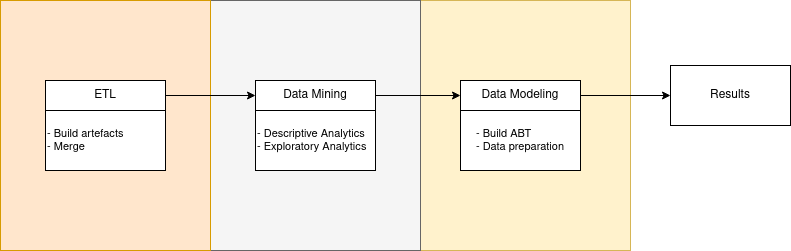

In [1]:
from IPython.display import Image
Image(filename='data_flow.drawio.png')

# 0. Libraries and Loading

## 0.1. Libraries

In [2]:
from utils import *
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings("ignore")
sns.set()

## 0.2. Loading Data

In [3]:
# create data_transactional
data_transactional = pd.read_parquet('dados/silver/data_transactional.parquet')

# create data_dimensional
data_dimensional = pd.read_parquet('dados/silver/data_dimensional.parquet')

# create data_features
data_features = pd.read_parquet('dados/silver/data_features.parquet')

# 1. Data Modeling

## 1.1. Creating ABT

### 1.1.1. Creating Window Flags gor History
- Past 3 months;
- Past 6 months;
- Past 9 months;
- Past 12 months.

In [4]:
# Apply the transformation
df_temp_01 = data_transactional.groupby('user_id').apply(calculate_flags).reset_index(drop=True)
df_temp_01 = df_temp_01.sort_values(by='id_date')

#
df_temp_01.head()

,id_date,user_id,id_tracks,plays,ultimos_03_meses_flag,ultimos_06_meses_flag,ultimos_09_meses_flag,ultimos_12_meses_flag
6529,2023-01-01,18,401,16,0,0,0,1
17245,2023-01-01,306,67,25,0,0,0,1
17246,2023-01-01,306,753,18,0,0,0,1
6901,2023-01-01,184,548,16,0,0,0,1
31649,2023-01-01,479,964,13,0,0,0,1


### 1.1.2. Creating First-Layer Explanatory Variables

In [5]:
# Group by 'id_tracks' and calculate statistics
df_temp_02 = df_temp_01.groupby('id_tracks').apply(calculate_statistics).reset_index()

# Sort by 'id_tracks'
df_temp_02 = df_temp_02.sort_values(by='id_tracks')

#
df_temp_02.head()

,id_tracks,VL_TOT_PLAYS,VL_MED_PLAYS,VL_MAX_PLAYS,VL_MIN_PLAYS,VL_TOT_U03M_PLAYS,VL_MED_U03M_PLAYS,VL_MAX_U03M_PLAYS,VL_MIN_U03M_PLAYS,VL_TOT_U06M_PLAYS,...,VL_MAX_U06M_PLAYS,VL_MIN_U06M_PLAYS,VL_TOT_U09M_PLAYS,VL_MED_U09M_PLAYS,VL_MAX_U09M_PLAYS,VL_MIN_U09M_PLAYS,VL_TOT_U12M_PLAYS,VL_MED_U12M_PLAYS,VL_MAX_U12M_PLAYS,VL_MIN_U12M_PLAYS
0,10,1242.0,14.785714,29.0,1.0,332.0,13.28,29.0,1.0,594.0,...,29.0,1.0,903.0,14.56,29.0,1.0,1242.0,14.79,29.0,1.0
1,100,1660.0,15.961538,29.0,1.0,465.0,15.50,29.0,1.0,1009.0,...,29.0,1.0,1408.0,16.37,29.0,1.0,1660.0,15.96,29.0,1.0
2,106,1656.0,16.727273,29.0,1.0,510.0,18.89,28.0,3.0,983.0,...,29.0,1.0,1387.0,16.71,29.0,1.0,1656.0,16.73,29.0,1.0
3,109,1627.0,15.796117,29.0,1.0,395.0,15.80,29.0,1.0,710.0,...,29.0,1.0,1177.0,15.29,29.0,1.0,1627.0,15.80,29.0,1.0
4,111,1433.0,16.101124,29.0,1.0,266.0,19.00,28.0,10.0,677.0,...,29.0,1.0,987.0,15.92,29.0,1.0,1433.0,16.10,29.0,1.0


### 1.1.3. Creating Second-Layer Explanatory Variables

In [6]:
# Group by 'id_tracks' and calculate ratios
df_temp_03 = df_temp_02.groupby('id_tracks').apply(calculate_ratios).reset_index()

#
df_temp_03.head()

,id_tracks,VL_RAZ_TOT_U03M_U06M_PLAYS,VL_RAZ_TOT_U03M_U09M_PLAYS,VL_RAZ_TOT_U03M_U12M_PLAYS,VL_RAZ_MED_U03M_U06M_PLAYS,VL_RAZ_MED_U03M_U09M_PLAYS,VL_RAZ_MED_U03M_U12M_PLAYS,VL_RAZ_MAX_U03M_U06M_PLAYS,VL_RAZ_MAX_U03M_U09M_PLAYS,VL_RAZ_MAX_U03M_U12M_PLAYS,...,VL_RAZ_MED_U06M_U09M_PLAYS,VL_RAZ_MED_U06M_U12M_PLAYS,VL_RAZ_MAX_U06M_U09M_PLAYS,VL_RAZ_MAX_U06M_U12M_PLAYS,VL_RAZ_MIN_U06M_U09M_PLAYS,VL_RAZ_MIN_U06M_U12M_PLAYS,VL_RAZ_TOT_U09M_U12M_PLAYS,VL_RAZ_MED_U09M_U12M_PLAYS,VL_RAZ_MAX_U09M_U12M_PLAYS,VL_RAZ_MIN_U09M_U12M_PLAYS
0,10,0.56,0.37,0.27,0.92,0.91,0.90,1.00,1.00,1.00,...,1.00,0.98,1.0,1.0,1.0,1.0,0.73,0.98,1.0,1.0
1,100,0.46,0.33,0.28,0.95,0.95,0.97,1.00,1.00,1.00,...,0.99,1.02,1.0,1.0,1.0,1.0,0.85,1.03,1.0,1.0
2,106,0.52,0.37,0.31,1.04,1.13,1.13,0.97,0.97,0.97,...,1.09,1.09,1.0,1.0,1.0,1.0,0.84,1.00,1.0,1.0
3,109,0.56,0.34,0.24,1.00,1.03,1.00,1.00,1.00,1.00,...,1.03,1.00,1.0,1.0,1.0,1.0,0.72,0.97,1.0,1.0
4,111,0.39,0.27,0.19,1.12,1.19,1.18,0.97,0.97,0.97,...,1.06,1.05,1.0,1.0,1.0,1.0,0.69,0.99,1.0,1.0


### 1.1.4. Merging Explanatory Variables with Data Features

In [7]:
abt_temp_01 = pd.merge(data_dimensional, df_temp_03, on=['id_tracks'], how='left')
abt_temp_01 = pd.merge(abt_temp_01, data_features, on=['id_artist'], how='left')

abt_temp_01.head()

,id_artist,id_tracks,id_genre,VL_RAZ_TOT_U03M_U06M_PLAYS,VL_RAZ_TOT_U03M_U09M_PLAYS,VL_RAZ_TOT_U03M_U12M_PLAYS,VL_RAZ_MED_U03M_U06M_PLAYS,VL_RAZ_MED_U03M_U09M_PLAYS,VL_RAZ_MED_U03M_U12M_PLAYS,VL_RAZ_MAX_U03M_U06M_PLAYS,...,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
0,78,350,7,0.42,0.33,0.26,0.95,1.01,1.01,1.00,...,159.0,640.0,860.0,710.0,2872.0,696.0,1109.0,2122.0,1259.0,129.0
1,394,964,7,0.50,0.36,0.26,0.92,0.91,0.92,0.97,...,37.0,593.0,1153.0,-143.0,768.0,784.0,1510.0,25.0,1563.0,105.0
2,107,467,1,0.51,0.32,0.25,1.02,0.96,0.95,1.00,...,155.0,551.0,789.0,584.0,46.0,828.0,1219.0,1231.0,1140.0,91.0
3,110,327,4,0.47,0.37,0.33,0.87,0.86,0.87,1.00,...,257.0,455.0,840.0,388.0,687.0,-173.0,1697.0,2255.0,1448.0,102.0
4,186,852,1,0.47,0.31,0.25,1.05,1.01,0.99,1.00,...,146.0,579.0,1109.0,3267.0,351.0,1314.0,565.0,1451.0,1125.0,99.0


### 1.1.5. Creating Data User Top 10

In [8]:
# Apply the function to get the result similar to the Spark SQL query
abt_temp_02 = collect_top_id_tracks(data_transactional)

abt_temp_02.head()

,user_id,top_10_id_tracks
0,1,"[231, 817, 266, 584, 556, 934, 597, 401, 643, ..."
1,10,"[595, 884, 533, 649, 365, 262, 631, 410, 950, ..."
2,100,"[747, 714, 563, 653, 983, 4, 396, 675, 327, 231]"
3,101,"[679, 592, 295, 548, 91, 439, 438, 244, 804, 115]"
4,102,"[328, 866, 169, 958, 508, 955, 523, 876, 682, ..."


### 1.1.5. Saving Gold Layer

In [9]:
data_02 = abt_temp_01.copy()

data_02.to_parquet('dados/gold/data_dimensional_features.parquet')

In [10]:
data_abt_temp_02 = abt_temp_02.copy()

data_abt_temp_02.to_parquet('dados/gold/data_user_top_10.parquet')

# 2. Data Preparation

In [30]:
data_03 = data_02.copy()

data_03.head()

,id_artist,id_tracks,id_genre,VL_RAZ_TOT_U03M_U06M_PLAYS,VL_RAZ_TOT_U03M_U09M_PLAYS,VL_RAZ_TOT_U03M_U12M_PLAYS,VL_RAZ_MED_U03M_U06M_PLAYS,VL_RAZ_MED_U03M_U09M_PLAYS,VL_RAZ_MED_U03M_U12M_PLAYS,VL_RAZ_MAX_U03M_U06M_PLAYS,...,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
0,78,350,7,0.42,0.33,0.26,0.95,1.01,1.01,1.00,...,159.0,640.0,860.0,710.0,2872.0,696.0,1109.0,2122.0,1259.0,129.0
1,394,964,7,0.50,0.36,0.26,0.92,0.91,0.92,0.97,...,37.0,593.0,1153.0,-143.0,768.0,784.0,1510.0,25.0,1563.0,105.0
2,107,467,1,0.51,0.32,0.25,1.02,0.96,0.95,1.00,...,155.0,551.0,789.0,584.0,46.0,828.0,1219.0,1231.0,1140.0,91.0
3,110,327,4,0.47,0.37,0.33,0.87,0.86,0.87,1.00,...,257.0,455.0,840.0,388.0,687.0,-173.0,1697.0,2255.0,1448.0,102.0
4,186,852,1,0.47,0.31,0.25,1.05,1.01,0.99,1.00,...,146.0,579.0,1109.0,3267.0,351.0,1314.0,565.0,1451.0,1125.0,99.0


In [33]:
generate_metadata(data_03)

,nome_variavel,tipo,quantidade_nulos,percentual_nulos,cardinalidade
0,VL_RAZ_MED_U06M_U12M_PLAYS,float64,0,0.0,32
1,VL_RAZ_MAX_U06M_U12M_PLAYS,float64,0,0.0,6
2,VL_RAZ_MIN_U06M_U09M_PLAYS,float64,0,0.0,6
3,VL_RAZ_MIN_U06M_U12M_PLAYS,float64,0,0.0,6
4,VL_RAZ_TOT_U09M_U12M_PLAYS,float64,0,0.0,28
5,VL_RAZ_MED_U09M_U12M_PLAYS,float64,0,0.0,20
6,VL_RAZ_MAX_U09M_U12M_PLAYS,float64,0,0.0,3
7,VL_RAZ_MIN_U09M_U12M_PLAYS,float64,0,0.0,4
8,Feature1,float64,0,0.0,228
9,Feature2,float64,0,0.0,178


In [34]:
data_03.id_genre = data_03.id_genre.astype(int)

## 3.1. Padronization

In [35]:
data_03_features = data_03.select_dtypes(include=['int64', 'float64'])

data_03_features

,id_genre,VL_RAZ_TOT_U03M_U06M_PLAYS,VL_RAZ_TOT_U03M_U09M_PLAYS,VL_RAZ_TOT_U03M_U12M_PLAYS,VL_RAZ_MED_U03M_U06M_PLAYS,VL_RAZ_MED_U03M_U09M_PLAYS,VL_RAZ_MED_U03M_U12M_PLAYS,VL_RAZ_MAX_U03M_U06M_PLAYS,VL_RAZ_MAX_U03M_U09M_PLAYS,VL_RAZ_MAX_U03M_U12M_PLAYS,...,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
0,7,0.42,0.33,0.26,0.95,1.01,1.01,1.00,1.00,1.00,...,159.0,640.0,860.0,710.0,2872.0,696.0,1109.0,2122.0,1259.0,129.0
1,7,0.50,0.36,0.26,0.92,0.91,0.92,0.97,0.97,0.97,...,37.0,593.0,1153.0,-143.0,768.0,784.0,1510.0,25.0,1563.0,105.0
2,1,0.51,0.32,0.25,1.02,0.96,0.95,1.00,1.00,1.00,...,155.0,551.0,789.0,584.0,46.0,828.0,1219.0,1231.0,1140.0,91.0
3,4,0.47,0.37,0.33,0.87,0.86,0.87,1.00,1.00,1.00,...,257.0,455.0,840.0,388.0,687.0,-173.0,1697.0,2255.0,1448.0,102.0
4,1,0.47,0.31,0.25,1.05,1.01,0.99,1.00,1.00,0.97,...,146.0,579.0,1109.0,3267.0,351.0,1314.0,565.0,1451.0,1125.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,4,0.65,0.47,0.36,1.01,1.03,1.00,1.00,1.00,1.00,...,96.0,671.0,893.0,589.0,981.0,69.0,927.0,142.0,1277.0,167.0
411,6,0.37,0.24,0.19,0.88,0.85,0.82,1.00,1.00,1.00,...,406.0,683.0,1099.0,1091.0,-891.0,14.0,1090.0,526.0,1185.0,158.0
412,7,0.54,0.37,0.31,0.99,0.97,0.98,1.00,1.00,1.00,...,432.0,666.0,753.0,1367.0,991.0,633.0,370.0,-380.0,1019.0,66.0
413,7,0.66,0.46,0.35,1.31,1.36,1.35,1.00,1.00,1.00,...,153.0,510.0,727.0,1103.0,254.0,903.0,566.0,796.0,1270.0,-2.0


In [36]:
scaler = StandardScaler()

scaled_features = scaler.fit_transform(data_03_features)

In [37]:
data_03_scaled = data_03.copy()

data_03_scaled[data_03_features.columns] = scaled_features

data_03_scaled.head()

,id_artist,id_tracks,id_genre,VL_RAZ_TOT_U03M_U06M_PLAYS,VL_RAZ_TOT_U03M_U09M_PLAYS,VL_RAZ_TOT_U03M_U12M_PLAYS,VL_RAZ_MED_U03M_U06M_PLAYS,VL_RAZ_MED_U03M_U09M_PLAYS,VL_RAZ_MED_U03M_U12M_PLAYS,VL_RAZ_MAX_U03M_U06M_PLAYS,...,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
0,78,350,1.384405,-1.225882,-0.440906,-0.330025,-0.562223,0.118961,0.103074,0.484123,...,-0.382317,0.548248,-0.087329,-0.390260,2.656129,0.351431,0.307168,1.082529,-0.178937,0.447442
1,394,964,1.384405,-0.301318,0.003570,-0.330025,-0.928506,-0.933681,-0.794318,-0.640380,...,-1.105771,-0.056627,1.907190,-1.208963,-0.147133,0.538841,0.868984,-1.023234,1.675704,-0.049439
2,107,467,-1.551854,-0.185748,-0.589064,-0.512639,0.292438,-0.407360,-0.495188,0.484123,...,-0.406037,-0.597153,-0.570643,-0.511194,-1.109089,0.632546,0.461282,0.187806,-0.904932,-0.339285
3,110,327,-0.083725,-0.648030,0.151729,0.948272,-1.538978,-1.460002,-1.292870,0.484123,...,0.198818,-1.832641,-0.223474,-0.699313,-0.255053,-1.499248,1.130978,1.216085,0.974113,-0.111549
4,186,852,-1.551854,-0.648030,-0.737223,-0.512639,0.658721,0.118961,-0.096347,0.484123,...,-0.459407,-0.236802,1.607672,2.063926,-0.702722,1.667564,-0.454996,0.408725,-0.996443,-0.173659


## 3.2. Clustering

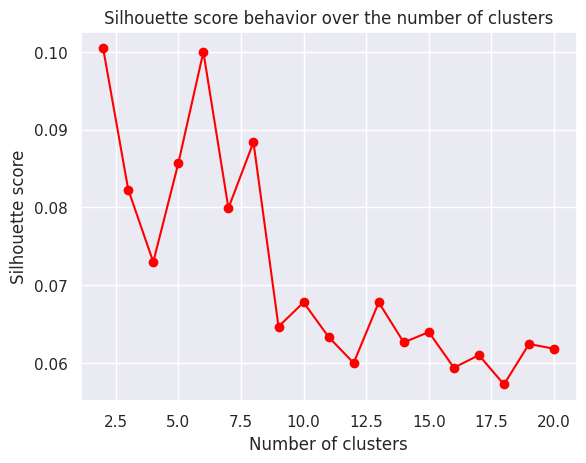

In [38]:
n_clusters = range(2, 21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(data_03_scaled[data_03_features.columns])
    preds = km.predict(data_03_scaled[data_03_features.columns])
    centers = km.cluster_centers_
    ssd.append(km.inertia_)
    score = silhouette_score(data_03_scaled[data_03_features.columns], preds, metric='euclidean')
    sc.append(score)
    # print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()

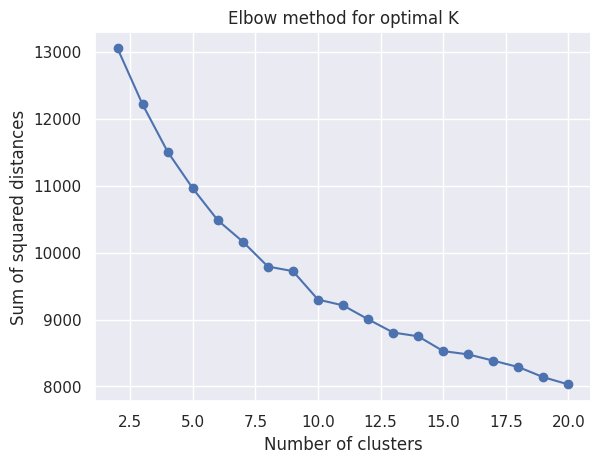

In [39]:
# finding out the proper number of clusters
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [40]:
data_03.id_tracks = data_03.id_tracks.astype(str)
data_03.id_genre = data_03.id_genre.astype(str)
data_03.id_artist = data_03.id_artist.astype(str)

In [41]:
# model
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster = kmeans.fit_predict(data_03_scaled[data_03_features.columns])

data_03_scaled['cluster'] = cluster

data_03_scaled

,id_artist,id_tracks,id_genre,VL_RAZ_TOT_U03M_U06M_PLAYS,VL_RAZ_TOT_U03M_U09M_PLAYS,VL_RAZ_TOT_U03M_U12M_PLAYS,VL_RAZ_MED_U03M_U06M_PLAYS,VL_RAZ_MED_U03M_U09M_PLAYS,VL_RAZ_MED_U03M_U12M_PLAYS,VL_RAZ_MAX_U03M_U06M_PLAYS,...,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,cluster
0,78,350,1.384405,-1.225882,-0.440906,-0.330025,-0.562223,0.118961,0.103074,0.484123,...,0.548248,-0.087329,-0.390260,2.656129,0.351431,0.307168,1.082529,-0.178937,0.447442,4
1,394,964,1.384405,-0.301318,0.003570,-0.330025,-0.928506,-0.933681,-0.794318,-0.640380,...,-0.056627,1.907190,-1.208963,-0.147133,0.538841,0.868984,-1.023234,1.675704,-0.049439,3
2,107,467,-1.551854,-0.185748,-0.589064,-0.512639,0.292438,-0.407360,-0.495188,0.484123,...,-0.597153,-0.570643,-0.511194,-1.109089,0.632546,0.461282,0.187806,-0.904932,-0.339285,3
3,110,327,-0.083725,-0.648030,0.151729,0.948272,-1.538978,-1.460002,-1.292870,0.484123,...,-1.832641,-0.223474,-0.699313,-0.255053,-1.499248,1.130978,1.216085,0.974113,-0.111549,1
4,186,852,-1.551854,-0.648030,-0.737223,-0.512639,0.658721,0.118961,-0.096347,0.484123,...,-0.236802,1.607672,2.063926,-0.702722,1.667564,-0.454996,0.408725,-0.996443,-0.173659,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,231,379,-0.083725,1.432237,1.633315,1.496114,0.170344,0.329490,0.003364,0.484123,...,0.947208,0.137309,-0.506395,0.136657,-0.983869,0.052179,-0.905745,-0.069123,1.234169,1
411,383,640,0.895029,-1.803734,-1.774334,-1.608323,-1.416883,-1.565267,-1.791421,0.484123,...,1.101644,1.539599,-0.024580,-2.357500,-1.101001,0.280548,-0.520140,-0.630396,1.047839,3
412,229,505,1.384405,0.160963,0.151729,0.583045,-0.073845,-0.302096,-0.196057,0.484123,...,0.882860,-0.815703,0.240323,0.149981,0.217262,-0.728198,-1.429927,-1.643128,-0.856869,1
413,154,63,1.384405,1.547808,1.485157,1.313500,3.833176,3.803210,3.493223,0.484123,...,-1.124809,-0.992692,-0.013062,-0.831960,0.792271,-0.453595,-0.249012,-0.111828,-2.264696,4


In [42]:
# from mpl_toolkits.mplot3d import Axes3D

# # visualizing clusters
# fig, ax = plt.subplots(figsize=(13, 11))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(data_03_features.values[cluster == 0, 0], data_03_features.values[cluster == 0, 1], s=50, c='red', label='Cluster 1')
# plt.scatter(data_03_features.values[cluster == 1, 0], data_03_features.values[cluster == 1, 1], s=50, c='blue', label='Cluster 2')
# plt.scatter(data_03_features.values[cluster == 2, 0], data_03_features.values[cluster == 2, 1], s=50, c='green', label='Cluster 3')
# plt.scatter(data_03_features.values[cluster == 3, 0], data_03_features.values[cluster == 3, 1], s=50, c='yellow', label='Cluster 4')
# plt.scatter(data_03_features.values[cluster == 4, 0], data_03_features.values[cluster == 4, 1], s=50, c='black', label='Cluster 5')

# # centroids
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
# plt.title('Clusters')
# plt.legend()
# plt.savefig('clusters.png')
# plt.show()

# 4. Results

## 4.1. Loading User Id Data

In [43]:
# loading data
data_user_top_10 = pd.read_parquet('dados/gold/data_user_top_10.parquet')

# checking
data_user_top_10.head()

,user_id,top_10_id_tracks
0,1,"[231, 817, 266, 584, 556, 934, 597, 401, 643, ..."
1,10,"[595, 884, 533, 649, 365, 262, 631, 410, 950, ..."
2,100,"[747, 714, 563, 653, 983, 4, 396, 675, 327, 231]"
3,101,"[679, 592, 295, 548, 91, 439, 438, 244, 804, 115]"
4,102,"[328, 866, 169, 958, 508, 955, 523, 876, 682, ..."


## 4.2. Recommendation

In [44]:
# instance class
recommender = SpotifyRecommender(data_03_scaled)

In [45]:
# for 1 random id_track
id_track = data_03_scaled[['id_tracks']].sample(1).id_tracks.values.tolist()
amount = 15

print(f'Recommend for this tracks: {id_track}')
print()

recommender_songs = recommender.spotify_recommendations(id_track, amount)

recommender_songs

Recommend for this tracks: ['244']



,id_tracks,id_artist,distance
7,767,139,10.804707
98,81,243,18.689710
408,704,120,20.175416
75,231,389,20.364247
367,367,65,21.857760
111,529,304,21.882769
200,436,26,23.092825
60,270,116,23.233058
250,977,263,23.639076
369,476,282,23.762030


In [46]:
# for 5 random id_tracks
id_track = data_03_scaled[['id_tracks']].sample(5).id_tracks.values.tolist()
amount = 15

print(f'Recommend for this tracks: {id_track}')
print()

recommender_songs = recommender.spotify_recommendations(id_track, amount)

recommender_songs

Recommend for this tracks: ['342', '654', '568', '679', '529']



,id_tracks,id_artist,distance
190,979,369,11.560302
138,521,337,13.722112
133,950,307,14.246822
200,436,26,14.591534
341,639,213,15.100712
35,734,69,15.161832
369,476,282,15.191701
267,241,2,15.192696
367,367,65,15.381249
135,593,237,15.413723


In [47]:
# applying for data users
amount = 10

data_user_top_10['user_id'] = data_user_top_10['user_id'].astype(int)
data_user_top_10['rec'] = data_user_top_10.apply(lambda x: recommender.spotify_recommendations(x.top_10_id_tracks, amount).id_tracks.values, axis=1)

data_user_top_10.sort_values('user_id')

,user_id,top_10_id_tracks,rec
0,1,"[231, 817, 266, 584, 556, 934, 597, 401, 643, ...","[515, 235, 408, 668, 187, 979, 644, 422, 608, ..."
111,2,"[15, 570, 595, 643, 517, 722, 421, 141, 135, 303]","[557, 644, 593, 95, 158, 200, 395, 544, 829, 505]"
222,3,"[499, 256, 137, 295, 952, 646, 843, 366, 254, ...","[507, 712, 144, 571, 892, 454, 99, 522, 88, 598]"
333,4,"[697, 790, 696, 265, 918, 982, 260, 871, 884, ...","[123, 449, 977, 574, 295, 571, 422, 169, 90, 439]"
444,5,"[499, 615, 201, 106, 572, 983, 490, 15, 646, 170]","[888, 593, 90, 123, 144, 332, 952, 999, 89, 386]"
...,...,...,...
439,495,"[301, 505, 661, 112, 475, 523, 130, 571, 613, ...","[538, 295, 826, 99, 50, 88, 160, 113, 697, 144]"
440,496,"[886, 904, 918, 615, 116, 463, 58, 77, 830, 781]","[516, 668, 193, 273, 958, 313, 392, 568, 734, ..."
441,497,"[669, 817, 279, 133, 850, 568, 841, 47, 282, 619]","[686, 122, 605, 344, 70, 372, 588, 950, 436, 453]"
442,498,"[949, 63, 868, 467, 361, 587, 88, 672, 296, 531]","[367, 892, 979, 50, 505, 295, 144, 113, 888, 712]"


# 5. Comments

- The main function of recommendation aims to recommend tracks based on the input track ID. It first filters the recommendation data to get the features of the specified track (id_track_features). It then computes the Manhattan distance between the specified track and all other tracks in the recommendation data. The function returns the top amount tracks with the smallest Manhattan distances.

- Manhattan function calculates the Manhattan distance between a given row and a matrix. The Manhattan distance is the sum of the absolute differences between the corresponding elements of the two vectors.